# Nifty File Format

Nifty (Neuroimaging Informatics Technology Initiative) is a file format to handle neuro images.
One nifty object contains:
- N-D array containing the image data (think of it as numpy array)
- (4,4) affine matrix mapping array coordinates to coordinates in some world space
- metadata in form of a header

Common package to use niftys is nibabel

The BIDS Toolbox also has a NII_Wrapper, that should be used instead of nibabel directly.

In [ ]:
# Lets build a simple nifty ourselves
import numpy as np
import nibabel as nib

import BIDS
from BIDS import NII, BIDS_Global_info

out_file = "/DATA/NAS/datasets_processed/NAKO/notes/NAKO_epidemiological.xlsx"

global_bids = BIDS_Global_info(datasets=["/DATA/NAS/datasets_processed/NAKO/MRT"], parents=["rawdata"])


In [ ]:
d: dict[str, list[str | None]] = {}
d_len = 0
ignore_list = [
    "SpecificCharacterSet",
    "ImageType",
    "InstanceCreationDate",
    "InstanceCreationTime",
    "SOPClassUID",
    "SOPInstanceUID",
    "StudyTime",
    "SeriesTime",
    "AcquisitionTime",
    "ContentTime",
    "AccessionNumber",
    "Modality",
    "StationName",
    "StudyDescription",
    "SeriesDescription",
    "InstitutionalDepartmentName",
    "ReferencedImageSequence",
    "BodyPartExamined",
    "ScanningSequence",
    "SequenceVariant",
    "MRAcquisitionType",
    "SequenceName",
    "AngioFlag",
    "SliceThickness",
    "RepetitionTime",
    "EchoTime",
    "NumberOfAverages",
    "ImagingFrequency",
    "ImagedNucleus",
    "EchoNumbers",
    "MagneticFieldStrength",
    "NumberOfPhaseEncodingSteps",
    "EchoTrainLength",
    "PercentSampling",
    "PercentPhaseFieldOfView",
    "PixelBandwidth",
    "SoftwareVersions",
    "ProtocolName",
    "DateOfLastCalibration",
    "TimeOfLastCalibration",
    "TransmitCoilName",
    "AcquisitionMatrix",
    "InPlanePhaseEncodingDirection",
    "FlipAngle",
    "VariableFlipAngleFlag",
    "SAR",
    "dBdt",
    "PatientPosition",
    "StudyInstanceUID",
    "SeriesInstanceUID",
    "StudyID",
    "SeriesNumber",
    "AcquisitionNumber",
    "ImagePositionPatient",
    "ImageOrientationPatient",
    "FrameOfReferenceUID",
    "SliceLocation",
    "SamplesPerPixel",
    "PhotometricInterpretation",
    "Rows",
    "Columns",
    "PixelSpacing",
    "BitsAllocated",
    "BitsStored",
    "HighBit",
    "PixelRepresentation",
    "SmallestImagePixelValue",
    "LargestImagePixelValue",
    "WindowCenter",
    "WindowWidth",
    "PerformedProcedureStepStartDate",
    "PerformedProcedureStepStartTime",
    "PerformedProcedureStepDescription",
    "RequestAttributesSequence",
    "OperatorsName",
    "PatientName",
    "ScanOptions",
    "RequestedProcedureDescription",
    "ReferringPhysicianName",
    "PhysiciansOfRecord",
    "RequestingPhysician",
    "DerivationDescription",
    "ContrastBolusAgent",
    "ContrastBolusVolume",
    "ContrastBolusTotalDose",
    "ContrastBolusIngredientConcentration",
]
import pandas as pd


def to_xls(whitelist=[], **qargs):
    global d_len

    for k, v in qargs.items():
        if k in ignore_list:
            continue
        if k not in d:
            d[k] = [None for i in range(d_len)]
        assert len(d[k]) == d_len, (k, len(d[k]), d_len)

        d[k].append(str(v))

    for k, v in d.items():
        if len(v) != d_len + 1:
            v.append(None)

    d_len = d_len + 1

In [ ]:
d: dict[str, list[str | None]] = {}
d_len = 0
for name, sub in global_bids.enumerate_subjects(sort=True):
    age_query = sub.new_query(flatten=True)
    for bf in age_query.loop_list(sort=True):
        if bf.has_json() and bf.has_nii():
            subject_name = name
            json = bf.open_json()
            to_xls(Subject_Name=subject_name, **json)
            break
    if d_len % 500 == 499:
        for k, v in d.items():
            if len(v) != d_len:
                print(k, len(v), d_len)
df = pd.DataFrame(d)
df.to_excel(out_file)

In [ ]:
df = pd.DataFrame(d)
df.to_excel(out_file)

In [ ]:
global_bids = BIDS_Global_info(datasets=["/DATA/NAS/datasets_processed/NAKO/MRT"], parents=["translated/derivatives"])  # ,


In [ ]:
from BIDS.bids_files import BIDS_FILE
import pandas as pd

out_file = "/DATA/NAS/datasets_processed/NAKO/notes/NAKO_vertebra_volumes.xlsx"


d: dict[str, list[str | None]] = {}
d_len = 0
json = {}
for name, sub in global_bids.enumerate_subjects(sort=True):
    print("SECURTY")
    break
    t2w_seg = sub.new_query()
    t2w_seg.filter("chunk", lambda x: True)
    t2w_seg.filter("acq", "iso")
    t2w_seg.filter_format("msk")
    # t2w_seg.filter_format("T2w")
    files_vert: list[BIDS_FILE] = []
    files_sub: list[BIDS_FILE] = []
    for bf in t2w_seg.loop_dict(sort=True):
        files_vert.append(bf["msk_seg-vert"][0])
        files_sub.append(bf["msk_seg-subreg"][0])
    NII.suppress_dtype_change_printout_in_set_array()
    out = {}
    out_post = {}
    out_body = {}
    for vert, sub in zip(files_vert, files_sub):
        vert_nii = vert.open_nii()
        sub_nii = sub.open_nii()
        sub_nii = sub_nii.map_labels_({50: 49, 48: 1, 47: 1, 46: 1, 45: 1, 44: 1, 43: 1, 42: 1, 41: 1, 40: 1}, verbose=False)
        for id in vert_nii.unique():
            if id == 26:
                continue
            label = vert_nii.extract_label(id)
            s = label.sum()
            if id not in out or out[id] < s:
                out[f"{id:02}"] = s
                out_post[f"{id:02}" + "_post"] = label.sum(where=sub_nii.extract_label(1).get_array().astype(bool))
                out_body[f"{id:02}" + "_body"] = label.sum(where=sub_nii.extract_label(49).get_array().astype(bool))
    out = dict(sorted(out.items()))
    out_post = dict(sorted(out_post.items()))
    out_body = dict(sorted(out_body.items()))

    # age_query = sub.new_query(flatten=True)
    # for bf in age_query.loop_list(sort=True):
    #    if bf.has_json() and bf.has_nii():
    #        json = bf.open_json()
    #        break
    # subject_name = name
    # white_list = [
    #    "InstitutionAddress",
    #    "PatientBirthDate",
    #    "PatientSex",
    #    "PatientAge",
    #    "PatientSize",
    #    "PatientWeight",
    # ]
    to_xls(Subject_Name=name, **json, **out, **out_post, **out_body)
    if d_len % 100 == 99 or d_len == 5:
        df = pd.DataFrame(dict(sorted(d.items())))
        df.to_excel(out_file)


# df = pd.DataFrame(dict(sorted(d.items())))
# df.to_excel(out_file)

In [ ]:
import pandas as pd

# df = pd.DataFrame(dict(sorted(d.items())))
# out_file = "/DATA/NAS/datasets_processed/NAKO/notes/NAKO_vertebra_volumes.xlsx"
# df.to_excel(out_file)

In [ ]:
import pandas as pd

vert_vol = pd.read_excel("/DATA/NAS/datasets_processed/NAKO/notes/NAKO_vertebra_volumes.xlsx")
epi = pd.read_excel("/DATA/NAS/datasets_processed/NAKO/notes/NAKO_epidemiological.xlsx")

out = pd.merge(epi, vert_vol, on=["Subject_Name"], how="inner")
len(out)

In [ ]:
%matplotlib inline

In [165]:
def pairs(seq, num_p=2):
    i = iter(seq)
    out = []
    for _ in range(num_p):
        out.append(next(i))
    for item in i:
        yield out
        out.pop(0)
        out.append(item)
        # prev = item


def make_graph(start=2, final=8, years=5):
    out["body"] = sum([out[f"{i:02}_body"] for i in range(start, final)])
    out["post"] = sum([out[f"{i:02}_post"] for i in range(start, final)])
    out["factor"] = out["post"] / out["body"]

    factors = []
    age = sorted(out["PatientAge"].unique())
    for i in pairs(age, num_p=years):
        factors.append(out.loc[out["PatientAge"].isin(i), "factor"].mean())

    import matplotlib.pyplot as plt
    import numpy as np

    fig = plt.figure()
    ax = plt.axes()
    x = range(73 - len(factors) - years // 2, 73 - years // 2)
    ax.plot(x, factors)
    from BIDS import v_idx2name

    ax.set_title(f"posterior/body; smoothing={years} years; from WK {v_idx2name[start]} to {v_idx2name[final-1]}")

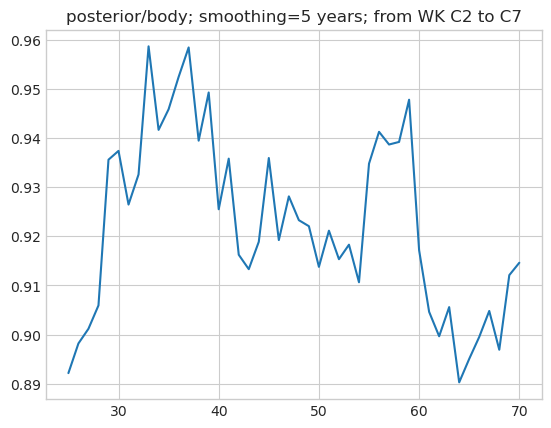

In [166]:
make_graph(start=2, final=8, years=5)


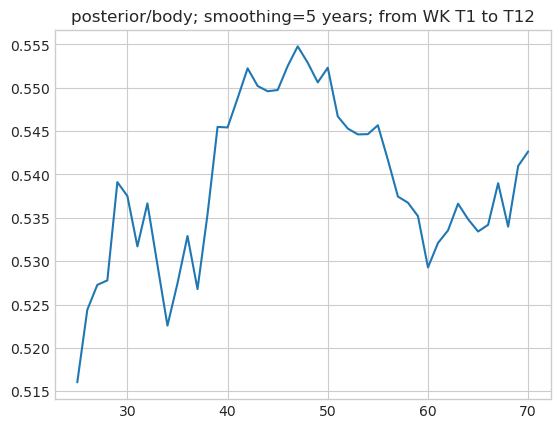

In [167]:
make_graph(start=8, final=20, years=5)


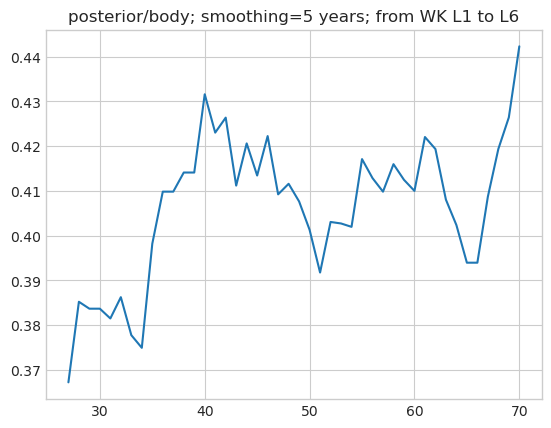

In [168]:
make_graph(start=20, final=26, years=5)


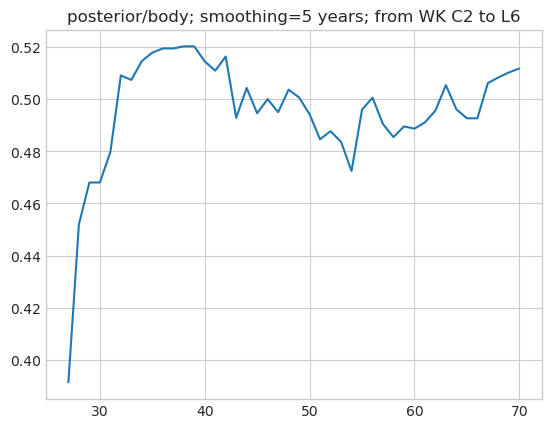

In [169]:
make_graph(start=2, final=26, years=5)


In [156]:
out["PatientAge"].value_counts().sort_index()


022Y     2
023Y     2
024Y     7
025Y     9
026Y     6
027Y     5
028Y     9
029Y    11
030Y     8
031Y     4
032Y     9
033Y    10
034Y    11
035Y     4
036Y     7
037Y     5
038Y    15
039Y     7
040Y    10
041Y    13
042Y    17
043Y    24
044Y    25
045Y    31
046Y    27
047Y    31
048Y    40
049Y    31
050Y    30
051Y    43
052Y    33
053Y    18
054Y    22
055Y    29
056Y    40
057Y    40
058Y    31
059Y    25
060Y    28
061Y    35
062Y    20
063Y    33
064Y    31
065Y    28
066Y    26
067Y    27
068Y    28
069Y    14
070Y    11
071Y     7
072Y     6
Name: PatientAge, dtype: int64

In [159]:
out["PatientSex"].value_counts()


M    497
F    488
Name: PatientSex, dtype: int64